# Pyramid blending

*Louis Martinez*

[Lecture from the University of Toronto](./References/pyr_toronto.pdf)  
[Lecture from Carnegie Mellon University](./References/pyr_cmellon.pdf)  
[The laplacian pyramid as a compact image code](./References/pyramid83.pdf)

This notebook implements image blending by Laplacian pyramid from scratch. This is a special case of image pyramids and, more generally, of multi-scale image analysis. Here, pyramids enable an image to be processed in different frequency bands separately.


## Imports and utility functions

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from scipy.ndimage import convolve

np.random.seed(0)
random.seed(0)

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

def show_pyramid(P, suptitle=None):
    fig, ax = plt.subplots(1, len(P), figsize=(3 * len(P), 5))
    if suptitle != None: fig.suptitle(suptitle)
    for i in range(len(P)):
        ax[i].axis('off')
        ax[i].imshow(np.clip(P[i], 0, 1))
        ax[i].set_title(f'Level {i}')
    plt.tight_layout()

In [2]:
im = imread('images/pavement.jpg')
im2 = imread('images/pangolin.jpg')
mask = imread('images/mask.jpg')

### Defining some filters

Here are implemented two different low-pass filters needed to build the Gaussian and Laplacian pyramids. One the one hand, the box-filter is the most simple one but it generates undesired artifacts on the final output (see Experiments section). On the other hand, the binomial filters outputs very satisfying results (visually speakind and purely subjective). The latter is known to be a good approximation of a Gaussian filter for specific values of the variance.

In [3]:
def box_filter(size):
    assert type(size) == int and size > 0, 'Size must be a positive integer'
    K = 1/size * np.ones(size)
    return K.reshape(-1,1) @ K.reshape(1,-1)

def binomial_filter(ntap):
    assert type(ntap) == int and ntap >= 2, 'n-tap must be an integer greater than 2'
    def build_coefficients():
        k = np.array([1,1])
        coefs = np.zeros(ntap + 2)
        coefs[-3:-1] = 1
        for i in range(ntap-1):
            coefs = convolve(coefs, k)
        return coefs[:-1]
    coefs = build_coefficients()
    return 1/coefs.sum()**2 * coefs.reshape(-1,1) @ coefs.reshape(1,-1)

def apply_filter(im, K):
    if im.ndim == 2:
        return convolve(im, K)
    else:
        return np.stack([convolve(im[:,:,k], K) for k in range(im.shape[2])], axis=2)

## Implementing image blending

**Important notes**

- Images will are denoted by $I$, the levels of Gaussian pyramids as $g_i$ and the levels of Laplacian pyramids as $L_i$
- Images are assumed to be square shaped, and of size $(2^N\times 2^N)$
- Images are assumed to have 3 channels (RGB). The same computations are independently applied to the three of them
- The formulas aim to keep a mathematical and rigurous framework even though the practical/programming part remains the easiest part to understand (personal point of view). Hence all the algorithms are described as they're implemented


### Gaussian pyramid

**The `REDUCE` function**

Building a Gaussian pyramid is based on the recursive use ot a `REDUCE` function. Given an image $g_i$ of shape* $2^N \times 2^N$, $\textrm{REDUCE}(g_i)$ performs the two following steps:  
1. **Blurring $g_i$**  
A low pass filter is applied to $g_i$ to cut high frequencies. It can be any common filter although some of them have a strong impact on the final result. For instance, one can use box-filters even though gaussian or binomial filters are preferred. The negative effect of box-filtering is dicussed in the Experiments section.
2. **Subsampling $g_i$**  
Once $g_i$ is blurred we halve its dimension to get $g_{i+1}$ of shape $2^{N-1} \times 2^{N-1}$

**Building the Gaussian pyramid**

Formally speaking, building a Gaussian pyramid consists in creating a series of images $(g_n)_{n\in[0,N-1]}$ with the following recurrence relation:

\begin{align}
g_{l+1} &= \textrm{REDUCE}(g_l) \\
g_{l+1}(i,j)&= \sum_{m=-k}^k\sum_{n=-k}^kw(m,n).g_l(2i-m,2j-n)
\end{align}

where $g_{l+1}(i,j)$ is the pixel value of image $g_{l+1}$ at location $(i,j)\in[0,2^{N-(l+1)}-1]^2$ and $w$ is the low-pass filter to be applied.
The first level of the pyramid $g_0$ is defined as the original image, i.e $g_0 = I$

In [4]:
def build_gaussian_pyramid(im, K):
    """
    Computes the Gaussian pyramid for a given image

    Parameters
    ------
    im: ndarray either of shape (row,col,channels) or (row,col)
        Input image for which to  build the pyramid

    K: ndarray of shape (2k+1,2k+1)
        Kernel of the low-pass filter to apply to the image at each stage of the reduce function

    Returns
    ------
    levels: list of ndarrays
        List containing all the levels of the pyramid
    """
    levels = [im]
    return reduce(im, K, levels)

def reduce(im, K, levels):
    """
    Recursively computes the next level of the pyramid given one level.
    Each level is stored in the `levels` list before jumping to the next stage.

    Parameters
    ------
    im: ndarray either of shape (row,col,channels) or (row,col)

    K: ndarray of shape (k,k)
        Kernel of the low-pass filter to apply to the image at each stage of the reduce function

    levels: list of ndarrays
        List containing the upper levels of the pyramid

    Returns
    ------
    levels: list of ndarrays
        List containing all the levels of the pyramid once the stopping criterion is fulfilled
    """
    if im.shape[0] <= 3 or im.shape[1] <= 3:
        return levels
    # Blur
    im = apply_filter(im, K)
    # Downsample
    im = im[::2,::2,:]
    # Save image
    levels.append(im)
    return reduce(im, K, levels)

### Laplacian Pyramid

<img src="https://raw.githubusercontent.com/lmartinez2001/Resources/main/pyramids/laplacian_pyr.png" width="512px">

**The `EXPAND` function**

The Laplacian of an image is built from its Gaussian pyramid. One need to introduce the `EXPAND` function. This function performs the two following steps (with the same notations as above):

1. **Doubling $g_i$ shape**  
Concretely we create a new image with twice the shape of $g_i$ and one pixel out of 2 is assigned the value of the pixel in $g_i$.
2. **Blurring the expanded version of $g_i$ with the filter**  
The same filter as for the `REDUCE` function is applied to $g_i$ expanded

Formally speaking the `EXPAND` function takes an image $g_{l+1}$ of shape $2^{N-(l+1)} \times 2^{N-(l+1)}$ as an input and outputs the expanded version $g^{exp}_{l}$ of shape $2^{N-l} \times 2^{N-l}$:

\begin{align}
g^{exp}_{l} &= \textrm{EXPAND}(g_{l+1}) \\
g^{exp}_{l}(i,j) &= 4\sum_{m=-k}^k\sum_{n=-k}^kw(m,n).g_{l+1}(\frac{i-m}{2},\frac{j-n}{2})
\end{align}

**Building the Laplacian pyramid**

The levels $L_j$ of the Laplacian pyramid are computed in the following way:

$$L_j = g_j - \textrm{EXPAND}(g_{j+1})\hspace{35pt}j\in[0,N-2]$$

Where $g_j$ it the $j$-th level of the Gaussian pyramid of the image.  
The image $L_{N-1}$ is basically the last level of the Gaussian pyramid, i.e $L_{N-1} = g_{N-1}
$

In [5]:
def expand(im, K):
    """
    Expands and blurs the input image to double it's size

    Parameters
    ------
    im: ndarray either of shape (row,col,channels) or (row,col)
        Input image to expand

    K: ndarray of shape (2k+1,2k+1)
        Kernel of the low-pass filter to apply to the image

    Returns
    ------
    expanded: ndarray either of shape (row,col,channels) or (row,col)
        Expanded image
    """
    w, h = im.shape[:2]
    out = np.zeros((2*w, 2*h,im.shape[2]))
    out[::2,::2,:] = im
    out = apply_filter(out, K)
    return 4 * out

def build_laplacian_pyramid(im, K):
    """
    Builds the Laplacian pyramid of an image. The Gaussian pyramid is also returned as it is required to build the Laplacian pyramid

    Parameters
    ------
    im: ndarray either of shape (x,x,channels) or (row,col)
        Input image for which to build the Laplacian pyramid.
        It has to be a squared image.

    K: ndarray of shape (2k+1,2k+1)
        Kernel of the low-pass filter to apply to the image
        The matrix must have an odd number of rows and columns

    Returns
    ------
    L: list of ndarrays
        Laplacian pyramid of the image

    G: list of ndarrays
        Gaussian pyramid of the image
    """
    L = []
    G = build_gaussian_pyramid(im, K)
    for i in range(len(G)-1):
        expanded = expand(G[i+1], K)
        h, w = G[i].shape[:2]
        expanded = expanded[:h, :w]
        L.append(G[i]-expanded)
    L.append(G[-1])
    return L, G

### Blending and collapsing Laplacian pyramids

Image blending is based on Laplacian pyramids blending. To do so we need both images to be blended together and a mask to guide how to blend them. We denote by $I_1$ and $I_2$ the images to blend and $M$ the mask image. Then we use the following algorithm:


**Image Blending algorithm**
1. Compute the Laplacian pyramids of both images $L^{I_1}$ and $L^{I_2}$
2. Compute the Gaussian pyramid of the mask $g^M$
3. Compute the blended Laplacian pyramid $L^B$ using the following formula for each level:
$$L^B_j = g^M_j \times  L^{I_1} + (1-g^M_j) \times L^{I_2}$$
4. Collapse $L^B$ to get the blended image $I^B$

**Collapsing a Laplacian pyramid**  
To retrieve the blended image, one we actually compute is gaussian pyramid and only keep the first level $g_0^B$ which is assumed to be the "original" image. However, we only have the Laplacian pyramid $L^B$. But we also know from the previous section that the last level of $L^B$ is also the last level of $g^B$, i.e $L^B_{N-1} = g^B_{N-1}$.  
The to the recurrence relation used to determine a Laplacoan pyramid, we can deduce all the levels of $g^B$, starting from the bottom:

\begin{align}
L^B_{N-2} = g^B_{N-2} - \textrm{EXPAND}(g^B_{N-1}) &\Rightarrow  g^B_{N-2} = L^B_{N-2} + \textrm{EXPAND}(g^B_{N-1}) \\
\ldots \hspace{35pt} &\Rightarrow \hspace{35pt} \ldots \\
L^B_{j} = g^B_{j} - \textrm{EXPAND}(g^B_{j+1}) &\Rightarrow g^B_{j} = L^B_{j} + \textrm{EXPAND}(g^B_{j+1}) \\
\ldots \hspace{35pt} &\Rightarrow \hspace{35pt} \ldots \\
L^B_{0} = g^B_{0} - \textrm{EXPAND}(g^B_{1}) &\Rightarrow g^B_{0} = L^B_{0} + \textrm{EXPAND}(g^B_{1})
\end{align}

Finally
$$g^B_{0} = I^B$$


**Reminder**  
All pixels values are assumed to be in the range $[0,1]$.

In [6]:
def blend_pyramids(L1, L2, Gmask):
    """
    Blends two Laplacian pyramids according to the provided mask

    Parameters
    ------
    L1, L2: lists of ndarrays
        Laplacian pyramids to blend
        Both pyramids must have the same length and image shapes at each level must match

    Gmask: list of ndarrays
        Gaussian pyramid of the mask to be applied

    Returns
    ------
    L: list of ndarrays
        Blended Laplacian pyramid
    """
    assert len(L1) == len(L2) == len(Gmask), 'Pyramids must have the same depth'
    L = []
    depth = len(Gmask)
    for l1, l2, g in zip(L1, L2, Gmask):
        L.append(l1 * g + l2 * (1-g))
    return L

def collapse_pyramid(pyr, K):
    """
    Collapses a Laplacian pyramid to retrieve the corresponding Gaussian pyramid

    Parameters
    ---
    pyr: list of ndarrays
        Laplacian pyramid to collapse

    K: ndarray of shape (2k+1,2k+1)
        Kernel of the low pass filter used to generate the Laplacian pyramid pyr

    Rreturns
    ------
    G: list of ndarrays
        Gaussian pyramid corresponding to the input Laplacian pyramid
    """
    L = pyr.copy()
    L.reverse()
    G = [L[0]]
    for i in range(1, len(L)):
        expanded = expand(G[i-1], K)
        h, w = L[i].shape[:2]
        expanded = expanded[:h, :w]
        G.append(L[i] + expanded)
    return G

## Experiments

In [7]:
def blend_images(im1, im2, mask, filter='binomial', filter_param=5, out_name=None):
    """
    Blends two images with respect to the specified mask

    Parameters
    ------
    im1: ndarray of shape (x,x,channels)
        Image to be blended

    im2: ndarray of shape (x,x,channels)
        Background image

    mask: ndarray of shape (x,x)
        Mask to apply to the image to blend

    filter: string, optional
        Type of filter to apply
        Can be either `binomial` or `box`
        Default value is `binonmial`

    filter_param: uint, optional
        Parameter of the filter.
        It corresponds either to the number of taps for the binomial filter or the size of the box filter
        Default value is 5

    out_name: string, optional
        If defined, saves the output result as an image.
        The format of the image should be precised. see :func:`skimage.io.imsave`
        Default value is None

    Returns
    ------
    result: ndarray
        Output image

    G_res: list of ndarrays
        Blended Gaussian pyramid

    LG_mask: list of ndarrays
        Gaussian pyramid of the mask

    L1: list of ndarrays
        Laplacian pyramid of im1

    L2: list of ndarrays
        Laplacian pyramid of im2

    L_res: list of ndarrays
        Blended Laplacian pyramid
    """
    K = None
    if filter == 'binomial':
        K = binomial_filter(filter_param)
    elif filter == 'box':
        K = box_filter(filter_param)
    else:
        raise ValueError('Invalid filter type. Should be either `binomial` or `box`')
    L1, G1 = build_laplacian_pyramid(im1, K)
    L2, G2 = build_laplacian_pyramid(im2, K)
    G_mask = build_gaussian_pyramid(mask, K)

    L_res = blend_pyramids(L1, L2, G_mask)
    G_res = collapse_pyramid(L_res, K)
    G_res.reverse()
    result = (np.clip(G_res[0], 0, 1) * 255).astype(np.uint8)
    if out_name is not None: imsave(out_name, result)
    return result, G_res, G_mask, L1, L2, L_res

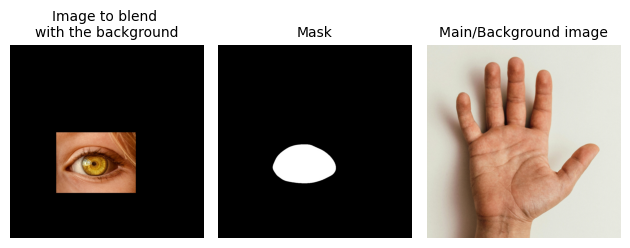

In [8]:
im1 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/pyramids/experiments/1_toblend.jpg') / 255
im2 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/pyramids/experiments/1_main.jpg') / 255
mask = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/pyramids/experiments/1_mask.jpg') / 255
out_name = '1_result.jpg'

fig, ax = plt.subplots(1,3)
ax[0].imshow(im1)
ax[0].axis('off')
ax[0].set_title('Image to blend \nwith the background', fontsize=10)
ax[1].imshow(mask)
ax[1].set_title('Mask', fontsize=10)
ax[1].axis('off')
ax[2].imshow(im2)
ax[2].axis('off')
ax[2].set_title('Main/Background image', fontsize=10)
plt.tight_layout()

In [9]:
eye_hand, G_res, G_mask, L1, L2, L_res = blend_images(im1, im2, mask, out_name=out_name)

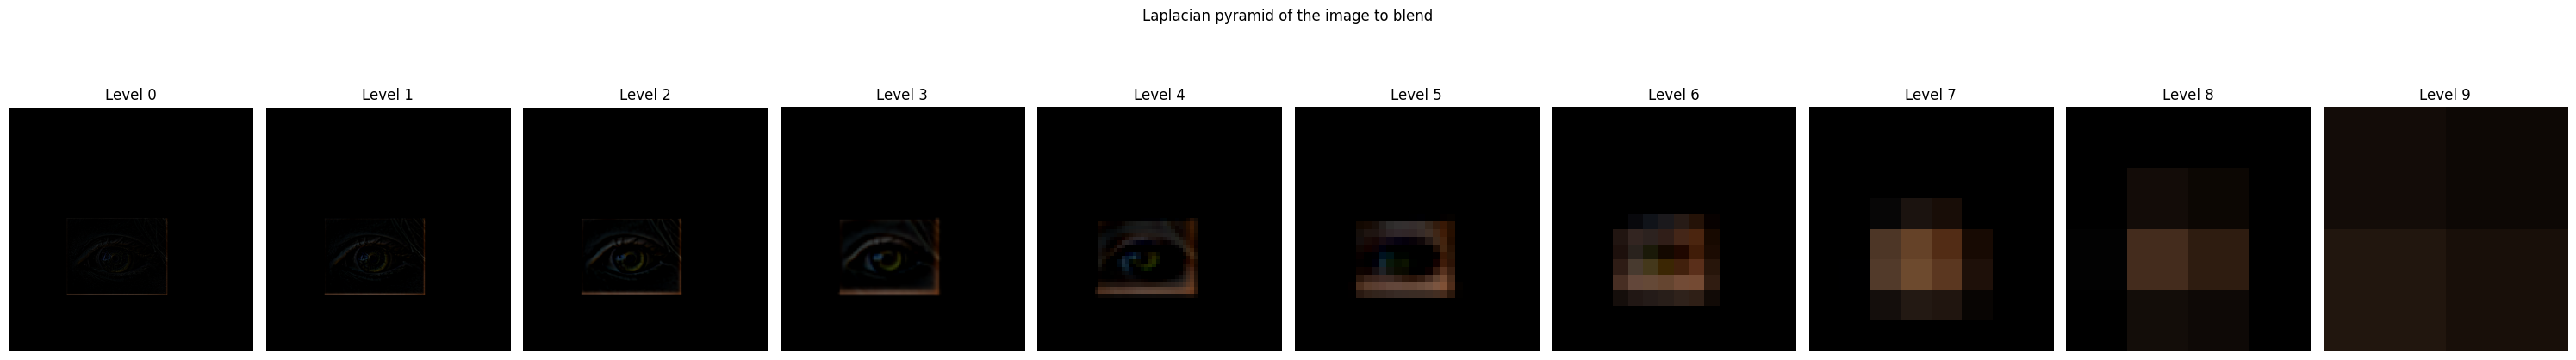

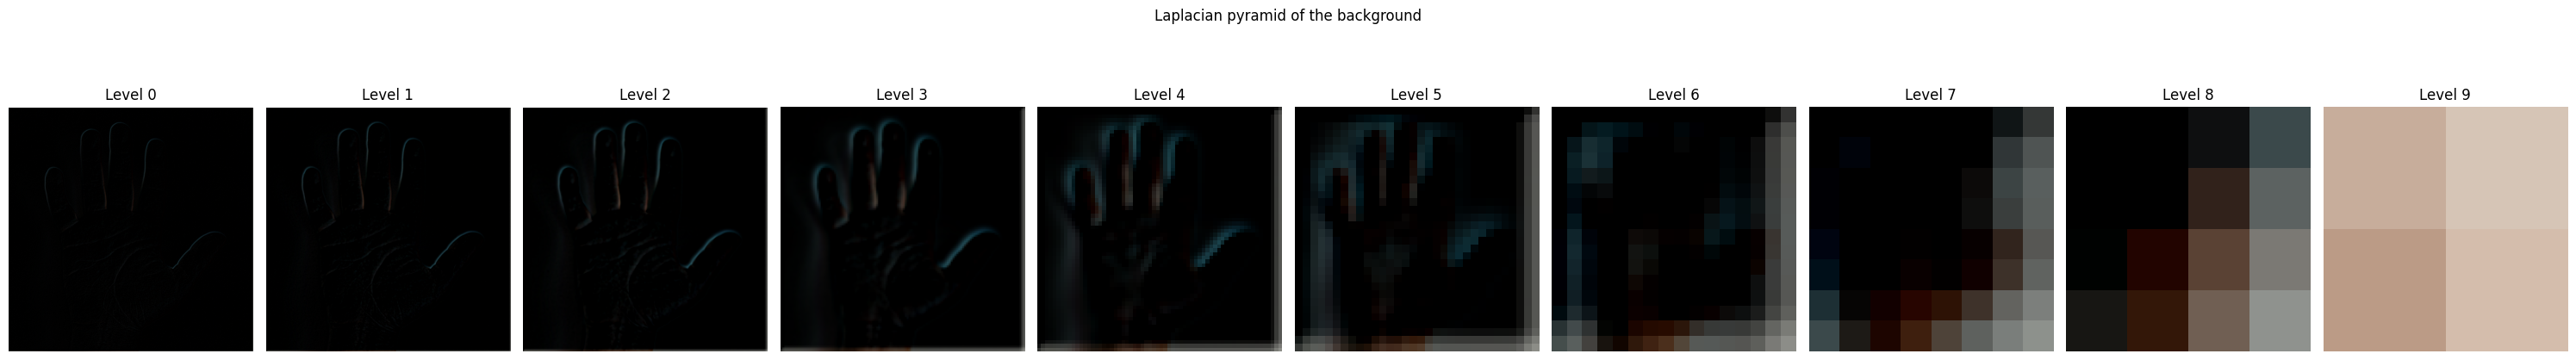

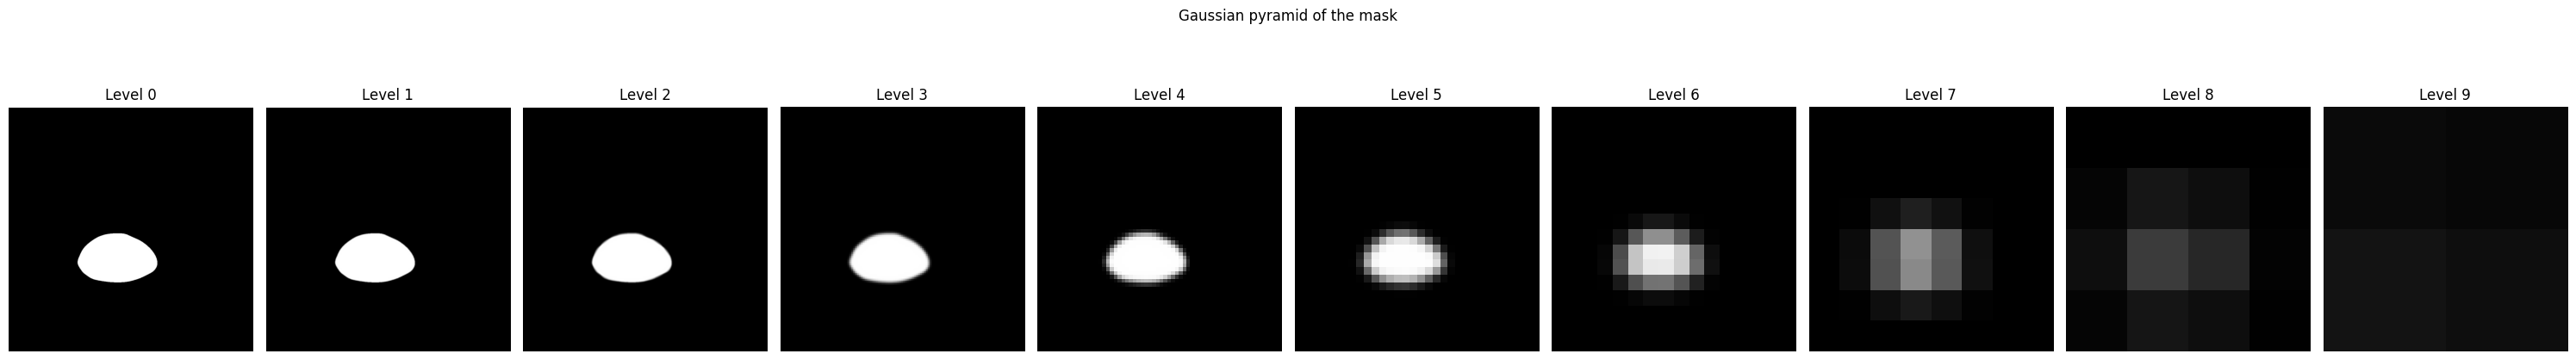

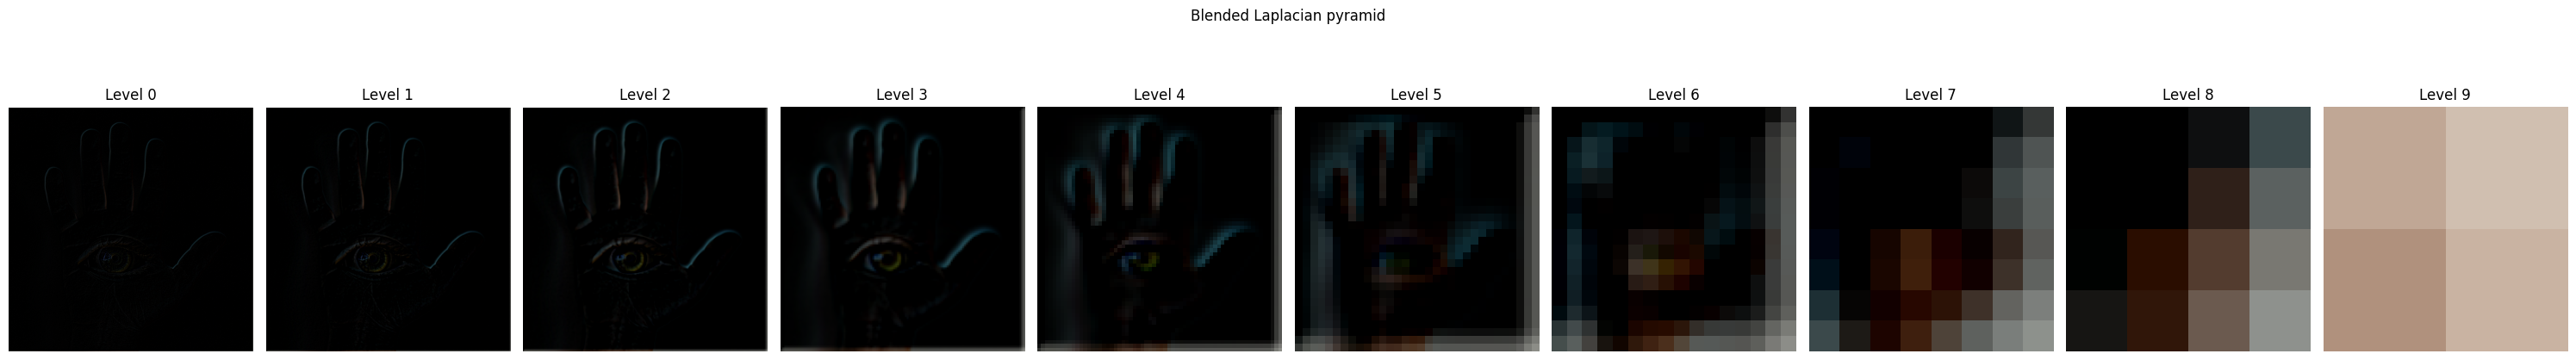

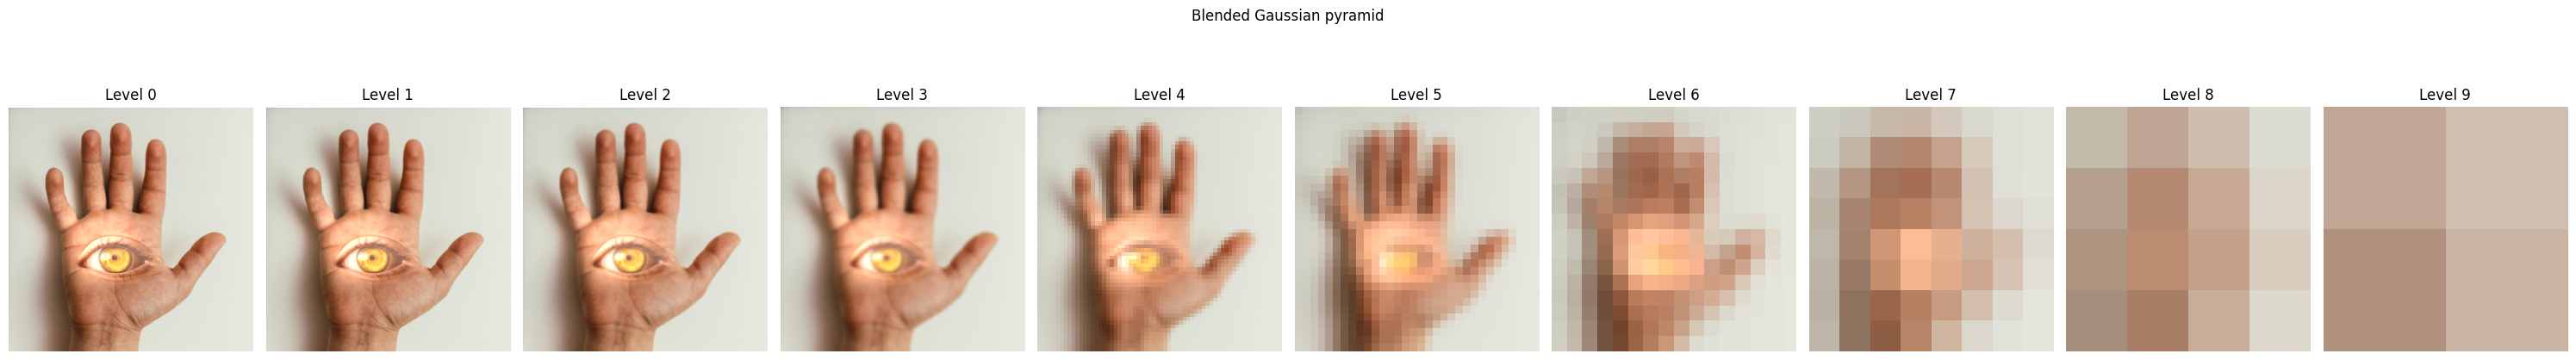

In [10]:
show_pyramid(L1, suptitle='Laplacian pyramid of the image to blend')
show_pyramid(L2, suptitle='Laplacian pyramid of the background')
show_pyramid(G_mask, suptitle='Gaussian pyramid of the mask')
show_pyramid(L_res, suptitle='Blended Laplacian pyramid')
show_pyramid(G_res, suptitle='Blended Gaussian pyramid')

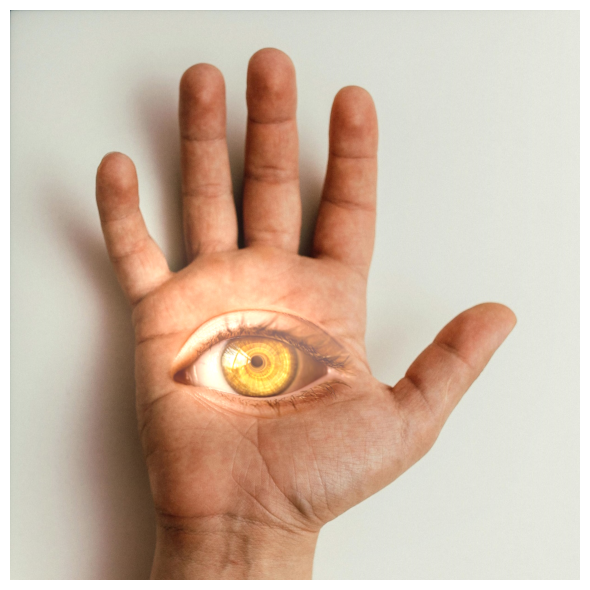

In [11]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(eye_hand)
plt.tight_layout()

#### Another example

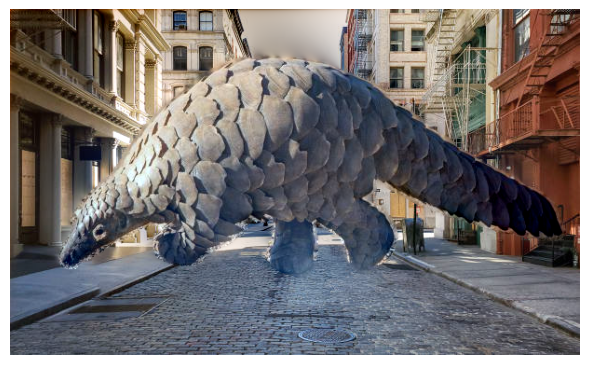

In [12]:
pangolin = imread('images/pyr_blending/pangolin.jpg') / 255
pavement = imread('images/pyr_blending/pavement.jpg') / 255
mask = imread('images/pyr_blending/mask.jpg') / 255

pangolin_pavement, G_res, G_mask, L1, L2, L_res = blend_images(pangolin, pavement, mask, out_name=out_name)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(pangolin_pavement)
plt.tight_layout()